In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [8]:
kwyk_final_dir = "/om2/user/sabeen/kwyk_data/kwyk_final_crop_rot_10-2"
features_dir = os.path.join(kwyk_final_dir,'train','features')
labels_dir = os.path.join(kwyk_final_dir,'train','labels')
features = os.listdir(features_dir)
labels = os.listdir(labels_dir)

In [19]:
# label = np.load(os.path.join(labels_dir,labels[128]))
label = np.load('/om2/user/sabeen/kwyk_data/kwyk_final_crop_rot_10-2/train/labels/pac_1000_aseg_168.npy')

In [22]:
np.unique(label)

array([0], dtype=int16)

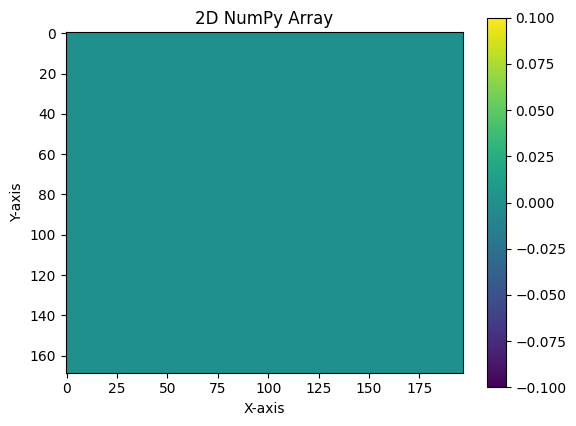

In [21]:
# Plot the array using matplotlib
plt.imshow(label[0,:,:], cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add color bar for reference
plt.title('2D NumPy Array')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [16]:
import json
with open(os.path.join(kwyk_final_dir,'percent_backgrounds.json')) as f:
    percent_backgrounds = json.load(f)

In [17]:
percent_backgrounds

{'/om2/user/sabeen/kwyk_data/kwyk_final_crop_rot_10-2/train/features/pac_1000_orig_168.npy': 0.45037841796875,
 '/om2/user/sabeen/kwyk_data/kwyk_final_crop_rot_10-2/train/labels/pac_1000_aseg_168.npy': 0.45037841796875,
 '/om2/user/sabeen/kwyk_data/kwyk_final_crop_rot_10-2/train/features/pac_1000_orig_167.npy': 0.45037841796875,
 '/om2/user/sabeen/kwyk_data/kwyk_final_crop_rot_10-2/train/labels/pac_1000_aseg_167.npy': 0.45037841796875,
 '/om2/user/sabeen/kwyk_data/kwyk_final_crop_rot_10-2/train/features/pac_1000_orig_166.npy': 0.45037841796875,
 '/om2/user/sabeen/kwyk_data/kwyk_final_crop_rot_10-2/train/labels/pac_1000_aseg_166.npy': 0.45037841796875,
 '/om2/user/sabeen/kwyk_data/kwyk_final_crop_rot_10-2/train/features/pac_1000_orig_165.npy': 0.45037841796875,
 '/om2/user/sabeen/kwyk_data/kwyk_final_crop_rot_10-2/train/labels/pac_1000_aseg_165.npy': 0.45037841796875,
 '/om2/user/sabeen/kwyk_data/kwyk_final_crop_rot_10-2/train/features/pac_1000_orig_164.npy': 0.45037841796875,
 '/om2/us

In [161]:
import torch
import nibabel as nib
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
from scipy.ndimage import affine_transform
import glob
import json

In [2]:
def load_brains(image_file: str, mask_file: str, file_path: str):
    # ensure that mask and image numbers match
    image_nr = image_file.split("_")[1]
    mask_nr = mask_file.split("_")[1]
    assert image_nr == mask_nr, "image and mask numbers do not match"

    image_path = os.path.join(file_path, image_file)
    mask_path = os.path.join(file_path, mask_file)

    brain = nib.load(image_path)
    brain_mask = nib.load(mask_path)

    brain = brain.get_fdata()
    brain_mask = brain_mask.get_fdata()
    brain_mask = brain_mask.astype(int)
    # apply skull stripping
    brain[brain_mask == 0] = 0

    return brain, brain_mask, image_nr


In [5]:
def crop(image: np.array, height: int, width: int) -> np.array:
    # find image-optimal crop
    for j in range(256):
        if (image[j] != 0).any():
            cut_top_temp = j
            break
    for j in range(256):
        if (image[255 - j] != 0).any():
            cut_bottom_temp = 255 - j
            break
    for j in range(256):
        if (image[:, j] != 0).any():
            cut_left_temp = j
            break
    for j in range(256):
        if (image[:, 255 - j] != 0).any():
            cut_right_temp = 255 - j
            break

    # image-optimal size:
    height_temp = cut_bottom_temp - cut_top_temp + 1
    width_temp = cut_right_temp - cut_left_temp + 1
    assert height_temp <= height, "Crop height is too big"
    assert width_temp <= width, "Crop width is too big"

    # crop image-optimal patch:
    image = image[
        cut_top_temp : cut_bottom_temp + 1, cut_left_temp : cut_right_temp + 1
    ]

    if image.shape[0] < 50 or image.shape[1] < 50:
        pass

    assert (image > 0).any(), "Crop is empty"

    # adjust the crop to largest rectangle
    if height_temp < height:
        diff = height - height_temp
        # even difference
        if (diff % 2) == 0:
            image = np.pad(image, ((diff // 2, diff // 2), (0, 0)))
        # odd difference
        else:
            image = np.pad(image, ((diff // 2, diff // 2 + 1), (0, 0)))
    if width_temp < width:
        diff = width - width_temp
        # even difference
        if (diff % 2) == 0:
            image = np.pad(image, ((0, 0), (diff // 2, diff // 2)))
        # odd difference
        else:
            image = np.pad(image, ((0, 0), (diff // 2, diff // 2 + 1)))

    return image


In [13]:
def create_plot(
        wandb_on: bool,
        image: np.array,
        caption: str,
        color_range=None,
        fig_path: str = None,
    ):
        if fig_path is not None and len(fig_path.split(".")) == 1:
            fig_path = fig_path + ".png"

        if color_range is not None:
            image = image.astype(np.uint8)
            channels = [cv2.LUT(image, color_range[:, i]) for i in range(3)]
            new_img = np.dstack(channels)

            if fig_path is not None:
                new_img_bgr = np.dstack([channels[2], channels[1], channels[0]])
                cv2.imwrite(fig_path, new_img_bgr)
            image = Image.fromarray(np.uint8(new_img))
        else:
            img_min = np.min(image)
            img_max = np.max(image)
            new_img = ((image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
            if fig_path is not None:
                cv2.imwrite(fig_path, new_img)
            image = Image.fromarray(np.uint8(new_img))
        # if wandb_on:
        #     image = wandb.Image(image, caption=caption)
        return image


In [63]:
pretrained = False
model_name = 'segformer'
nr_of_classes = 50
image_shape = (162, 194)

# color map to get always the same colors for classes
# if nr_of_classes in [2, 6, 16, 50, 106]:  # freesurfer colors available
#     colors = __rgb_map_for_data(nr_of_classes)
# else:
#     colors = plt.cm.hsv(np.linspace(0, 1, config.nr_of_classes))
#     colors = colors[:, :-1] * 255
# self.color_range = np.zeros((256, 3))
# self.color_range[: colors.shape[0], :] = colors

# load always the same image from validation set
image_file = "pac_36_orig.nii.gz"
mask_file = "pac_36_aseg.nii.gz"
file_path = "/nese/mit/group/sig/users/matth406/nobrainer_data/data/SharedData/segmentation/freesurfer_asegs/"
brain, mask, _ = load_brains(image_file, mask_file, file_path)
# mask = mapping(mask, nr_of_classes=self.nr_of_classes)

brain_slices = []
mask_slices = []

# randomly select slices in 3 directions
slice_idx = [125, 150]
normalization_constants = np.load(
    "/nese/mit/group/sig/users/matth406/nobrainer_data_norm/data_prepared_medium/normalization_constants.npy"
)
brain_slices = torch.empty(
    (len(slice_idx) * 3, 1, image_shape[0], image_shape[1])
)
mask_slices = torch.empty(
    (len(slice_idx) * 3, 1, image_shape[0], image_shape[1]),
    dtype=torch.long,
)
i = 0
logging_dict = {}
for d in range(3):
    for slice_id in slice_idx:
        if d == 0:
            brain_slice = crop(
                brain[slice_id, :, :], image_shape[0], image_shape[1]
            )
            mask_slice = crop(
                mask[slice_id, :, :], image_shape[0], image_shape[1]
            )
        if d == 1:
            brain_slice = crop(
                brain[:, slice_id, :], image_shape[0], image_shape[1]
            )
            mask_slice = crop(
                mask[:, slice_id, :], image_shape[0], image_shape[1]
            )
        if d == 2:
            brain_slice = crop(
                brain[:, :, slice_id], image_shape[0], image_shape[1]
            )
            mask_slice = crop(
                mask[:, :, slice_id], image_shape[0], image_shape[1]
            )

        logging_dict[f"Image d{d} c{slice_id}"] = create_plot(
            False,
            brain_slice,
            caption="Raw Image",  fig_path=f'/om2/user/sabeen/test_imgs/20240406_raw_d{d}_c{slice_id}.png'
        )
        # logging_dict[f"True Mask d{d} c{slice_id}"] = create_plot(
        #     False,
        #     mask_slice,
        #     caption="True Mask",
        #     # color_range=self.color_range,
        #     fig_path=f'/om2/user/sabeen/test_imgs/20240406_true_mask_d{d}_c{slice_id}.png'
        # )
        brain_slice = (
            brain_slice - normalization_constants[0]
        ) / normalization_constants[1]
        brain_slice = torch.from_numpy(brain_slice).to(torch.float32)
        brain_slice = brain_slice[None, None]
        brain_slices[i] = brain_slice

        mask_slice = torch.tensor(mask_slice)[None, None].long()
        mask_slices[i] = mask_slice

        i += 1

In [64]:
len(brain_slices)

6

In [145]:
def draw_value_from_distribution(
    hyperparameter,
    size=1,
    distribution="uniform",
    centre=0.0,
    default_range=10.0,
    positive_only=False,
    return_as_tensor=False,
    batchsize=None,
):
    """Sample values from a uniform, or normal distribution of given hyperparameters.
    These hyperparameters are to the number of 2 in both uniform and normal cases.
    :param hyperparameter: values of the hyperparameters. Can either be:
    1) None, in each case the two hyperparameters are given by [center-default_range, center+default_range],
    2) a number, where the two hyperparameters are given by [centre-hyperparameter, centre+hyperparameter],
    3) a sequence of length 2, directly defining the two hyperparameters: [min, max] if the distribution is uniform,
    [mean, std] if the distribution is normal.
    4) a numpy array, with size (2, m). In this case, the function returns a 1d array of size m, where each value has
    been sampled independently with the specified hyperparameters. If the distribution is uniform, rows correspond to
    its lower and upper bounds, and if the distribution is normal, rows correspond to its mean and std deviation.
    5) a numpy array of size (2*n, m). Same as 4) but we first randomly select a block of two rows among the
    n possibilities.
    6) the path to a numpy array corresponding to case 4 or 5.
    7) False, in which case this function returns None.
    :param size: (optional) number of values to sample. All values are sampled independently.
    Used only if hyperparameter is not a numpy array.
    :param distribution: (optional) the distribution type. Can be 'uniform' or 'normal'. Default is 'uniform'.
    :param centre: (optional) default centre to use if hyperparameter is None or a number.
    :param default_range: (optional) default range to use if hyperparameter is None.
    :param positive_only: (optional) whether to reset all negative values to zero.
    :param return_as_tensor: (optional) whether to return the result as a tensorflow tensor
    :param batchsize: (optional) if return_as_tensor is true, then you can sample a tensor of a given batchsize. Give
    this batchsize as a tensorflow tensor here.
    :return: a float, or a numpy 1d array if size > 1, or hyperparameter is itself a numpy array.
    Returns None if hyperparameter is False.
    """

    # return False is hyperparameter is False
    if hyperparameter is False:
        return None

    # reformat parameter_range
    # hyperparameter = load_array_if_path(hyperparameter, load_as_numpy=True)
    hyperparameter = None
    if not isinstance(hyperparameter, np.ndarray):
        if hyperparameter is None:
            hyperparameter = np.array(
                [[centre - default_range] * size, [centre + default_range] * size]
            )
        elif isinstance(hyperparameter, (int, float)):
            hyperparameter = np.array(
                [[centre - hyperparameter] * size, [centre + hyperparameter] * size]
            )
        elif isinstance(hyperparameter, (list, tuple)):
            assert (
                len(hyperparameter) == 2
            ), "if list, parameter_range should be of length 2."
            hyperparameter = np.transpose(np.tile(np.array(hyperparameter), (size, 1)))
        else:
            raise ValueError(
                "parameter_range should either be None, a number, a sequence, or a numpy array."
            )
    elif isinstance(hyperparameter, np.ndarray):
        assert (
            hyperparameter.shape[0] % 2 == 0
        ), "number of rows of parameter_range should be divisible by 2"
        n_modalities = int(hyperparameter.shape[0] / 2)
        modality_idx = 2 * np.random.randint(n_modalities)
        hyperparameter = hyperparameter[modality_idx : modality_idx + 2, :]

    # draw values as tensor
    if return_as_tensor:
        print("dont return as tensor?")
        parameter_value = None
        # shape = KL.Lambda(lambda x: tf.convert_to_tensor(hyperparameter.shape[1], 'int32'))([])
        # if batchsize is not None:
        #     shape = KL.Lambda(lambda x: tf.concat([x[0], tf.expand_dims(x[1], axis=0)], axis=0))([batchsize, shape])
        # if distribution == 'uniform':
        #     parameter_value = KL.Lambda(lambda x: tf.random.uniform(shape=x,
        #                                                             minval=hyperparameter[0, :],
        #                                                             maxval=hyperparameter[1, :]))(shape)
        # elif distribution == 'normal':
        #     parameter_value = KL.Lambda(lambda x: tf.random.normal(shape=x,
        #                                                            mean=hyperparameter[0, :],
        #                                                            stddev=hyperparameter[1, :]))(shape)
        # else:
        #     raise ValueError("Distribution not supported, should be 'uniform' or 'normal'.")

        # if positive_only:
        #     parameter_value = KL.Lambda(lambda x: K.clip(x, 0, None))(parameter_value)

    # draw values as numpy array
    else:
        if distribution == "uniform":
            parameter_value = np.random.uniform(
                low=hyperparameter[0, :], high=hyperparameter[1, :]
            )
        elif distribution == "normal":
            parameter_value = np.random.normal(
                loc=hyperparameter[0, :], scale=hyperparameter[1, :]
            )
        else:
            raise ValueError(
                "Distribution not supported, should be 'uniform' or 'normal'."
            )

        if positive_only:
            parameter_value[parameter_value < 0] = 0

    return parameter_value

def create_affine_transformation_matrix(
    n_dims, scaling=None, rotation=None, shearing=None, translation=None
):
    """
    From https://github.com/MGH-LEMoN/photo-reconstruction/blob/main/scripts/hcp_replicate_photos.py#L85C40-L85C40.
    Create a 4x4 affine transformation matrix from specified values
    :param n_dims: integer
    :param scaling: list of 3 scaling values
    :param rotation: list of 3 angles (degrees) for rotations around 1st, 2nd, 3rd axis
    :param shearing: list of 6 shearing values
    :param translation: list of 3 values
    :return: 4x4 numpy matrix
    """

    T_scaling = np.eye(n_dims + 1)
    T_shearing = np.eye(n_dims + 1)
    T_translation = np.eye(n_dims + 1)

    if scaling is not None:
        T_scaling[np.arange(n_dims + 1), np.arange(n_dims + 1)] = np.append(scaling, 1)

    if shearing is not None:
        shearing_index = np.ones((n_dims + 1, n_dims + 1), dtype="bool")
        shearing_index[np.eye(n_dims + 1, dtype="bool")] = False
        shearing_index[-1, :] = np.zeros((n_dims + 1))
        shearing_index[:, -1] = np.zeros((n_dims + 1))
        T_shearing[shearing_index] = shearing

    if translation is not None:
        T_translation[
            np.arange(n_dims), n_dims * np.ones(n_dims, dtype="int")
        ] = translation

    if n_dims == 2:
        if rotation is None:
            rotation = np.zeros(1)
        else:
            rotation = np.asarray(rotation) * (np.pi / 180)
        T_rot = np.eye(n_dims + 1)
        T_rot[np.array([0, 1, 0, 1]), np.array([0, 0, 1, 1])] = [
            np.cos(rotation[0]),
            np.sin(rotation[0]),
            np.sin(rotation[0]) * -1,
            np.cos(rotation[0]),
        ]
        return T_translation @ T_rot @ T_shearing @ T_scaling

    else:
        if rotation is None:
            rotation = np.zeros(n_dims)
        else:
            rotation = np.asarray(rotation) * (np.pi / 180)
        T_rot1 = np.eye(n_dims + 1)
        T_rot1[np.array([1, 2, 1, 2]), np.array([1, 1, 2, 2])] = [
            np.cos(rotation[0]),
            np.sin(rotation[0]),
            np.sin(rotation[0]) * -1,
            np.cos(rotation[0]),
        ]
        T_rot2 = np.eye(n_dims + 1)
        T_rot2[np.array([0, 2, 0, 2]), np.array([0, 0, 2, 2])] = [
            np.cos(rotation[1]),
            np.sin(rotation[1]) * -1,
            np.sin(rotation[1]),
            np.cos(rotation[1]),
        ]
        T_rot3 = np.eye(n_dims + 1)
        T_rot3[np.array([0, 1, 0, 1]), np.array([0, 0, 1, 1])] = [
            np.cos(rotation[2]),
            np.sin(rotation[2]),
            np.sin(rotation[2]) * -1,
            np.cos(rotation[2]),
        ]
        return T_translation @ T_rot3 @ T_rot2 @ T_rot1 @ T_shearing @ T_scaling

def get_affine_matrix(image):
        # which augmentations to perform (based on SynthSeg)
        scaling_bounds = 0.2  # the scaling coefficients will be sampled from U(1-scaling_bounds; 1+scaling_bounds)
        rotation_bounds = 15  # the rotation angles will be sampled from U(-rotation_bounds; rotation_bounds)
        shearing_bounds = 0.012  # the shearing coefficients will be sampled from U(-shearing_bounds; shearing_bounds)
        translation_bounds = False  # no translation is performed, as this is already modelled by the random cropping
        enable_90_rotations = False

        # randomize augmentations
        batchsize = 1
        n_dims = 2
        center = np.array([image.shape[0] // 2, image.shape[1] // 2])

        scaling = draw_value_from_distribution(
            scaling_bounds,
            size=n_dims,
            centre=1,
            default_range=0.15,
            return_as_tensor=False,
            batchsize=batchsize,
        )

        rotation = draw_value_from_distribution(
            rotation_bounds,
            size=1,
            default_range=15.0,
            return_as_tensor=False,
            batchsize=batchsize,
        )

        shearing = draw_value_from_distribution(
            shearing_bounds,
            size=n_dims**2 - n_dims,
            default_range=0.01,
            return_as_tensor=False,
            batchsize=batchsize,
        )
        affine_matrix = create_affine_transformation_matrix(
            n_dims=2,
            scaling=None,
            rotation=None,
            shearing=shearing,
            translation=None,
        )
        
        # Translate the center back to the origin
        translation_matrix1 = np.array(
            [[1, 0, -center[0]], [0, 1, -center[1]], [0, 0, 1]]
        )

        # Translate the center to the original position
        translation_matrix2 = np.array(
            [[1, 0, center[0]], [0, 1, center[1]], [0, 0, 1]]
        )

        final_matrix = translation_matrix2 @ affine_matrix @ translation_matrix1
        return final_matrix

In [171]:
def null_half(image: np.array, mask: np.array, keep_left=True):
    df = pd.read_csv("/om2/user/sabeen/nobrainer_data_norm/class_mapping.csv")
    null_image = image.copy()
    null_mask = mask.copy()
    if keep_left:
        # label_mapping = {df['original'][i]: (df['original'][i] if not ('Right-' in df['label'][i] or '-rh-' in df['label'][i]) else 0) for i in df['index']}
        null_classes = {df['original'][i] for i in df['index'] if 'Right' in df['label'][i] or '-rh-' in df['label'][i]}
    else:
        # label_mapping = {df['original'][i]: (df['original'][i] if not ('Left-' in df['label'][i] or '-lh-' in df['label'][i]) else 0) for i in df['index']}
        null_classes = {df['original'][i] for i in df['index'] if 'Right' in df['label'][i] or '-rh-' in df['label'][i]}
    for label in null_classes:
        null_image[mask == label] = 0
        null_mask[mask == label] = 0
    
    return null_image, null_mask, null_classes

In [162]:
image = brain_slices[0]
mask = mask_slices[0]
# image = image + torch.min(image)

In [175]:
image = np.array(image)
mask = np.array(mask)
print(np.unique(mask))
image, mask, null_classes = null_half(image,mask,keep_left=True)
print(np.unique(mask))
print([i in null_classes for i in np.unique(mask)])

[   0   15   16   24   63   85  254  255 1005 1014 1028 2000]
[   0   15   16   24   63   85  254  255 1005 1014 1028 2000]
[False, False, False, False, False, False, False, False, False, False, False, False]


In [155]:
aff = get_affine_matrix(image)
image = affine_transform(image.squeeze(), aff, mode="constant")
mask = affine_transform(mask.squeeze(), aff, mode="constant",order=0)


In [156]:
np.unique(image)
i_test = image.copy()
# i_test[mask == 0] = 0

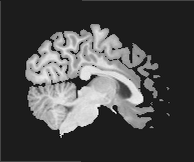

In [157]:
create_plot(False,i_test,'',None,None)

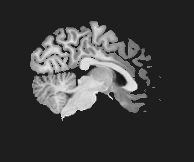

In [144]:
create_plot(False,i_test,'',None,None)

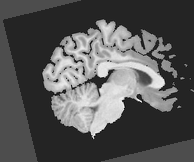

In [118]:
create_plot(False,image,'',None,None)

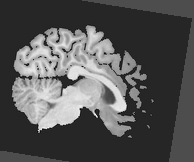

In [124]:
create_plot(False,image,'',None,None)

In [136]:
image = brain_slices[0]
mask = mask_slices[0]
# image = image + torch.min(image)
image = torch.flip(image, dims=(2,))
mask = torch.flip(mask, dims=(2,))

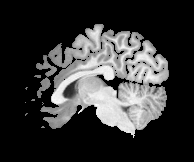

In [137]:
create_plot(False,np.array(image.squeeze()),'',None,None)